In [2]:
pwd

'/Users/curiostudio/Documents/GitHub/target_neuron_ablation'

In [3]:
ls

README.md                       neuron.yml
Untitled.ipynb                  neuron_mac.yml
anaconda_projects/              notebook_select_longtail.ipynb
c4_pythia_unigram_alignment.py  output_data/
experiments/                    pyproject.toml
files/                          pythia-unigrams.npy
gemini_help.ipynb               requirements.txt
justfile                        src/
mypy.ini                        unigram_data/


In [113]:
# 步骤0: 初始化和环境设置 - 导入所需库和配置日志
import logging
import typing as t

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from scipy import stats
from transformers import AutoTokenizer

# 步骤0.1: 导入自定义模块
from neuron_analyzer import settings
from neuron_analyzer.abl_util import get_pile_unigram_distribution

# 步骤0.2: 设置日志记录
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# 步骤2: 加载单字符分布函数
def load_unigram(model_name,device)->torch.Tensor:
    """加载基于模型类型的单字符分布。"""
    # 根据模型类型加载单字符分布
    if "pythia" in model_name:
        file_path="pythia-unigrams.npy"
        unigram_distrib = get_pile_unigram_distribution(
            device=device, pad_to_match_W_U=True,
            file_path=file_path
        )
        logger.info(f"Loaded unigram freq from {file_path}")
    else:
        raise Exception(f"No unigram distribution for {model_name}")

    return unigram_distrib


# 步骤3: 单字符分析器类 - 用于分析基于模型特定单字符计数的单词频率
class UnigramAnalyzer:
    """用于基于模型特定单字符计数分析单词频率的类。"""

    # 模型特定常量配置
    MODEL_CONFIGS = {
        "pythia": {"W_U_SIZE": 50304, "TRUE_VOCAB_SIZE": 50277},
        "phi-2": {"W_U_SIZE": 51200, "TRUE_VOCAB_SIZE": 50295},
    }

    # 步骤3.1: 初始化单字符分析器
    def __init__(
        self,
        model_name: str = "pythia-410m",
        unigram_file_path: t.Optional[str] = None,
        tokenizer: t.Optional[AutoTokenizer] = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """初始化UnigramAnalyzer，包含模型和分词器信息。"""
        self.model_name = model_name
        self.device = device

        # 确定模型类型并设置词汇表大小
        if "pythia" in model_name:
            self.model_type = "pythia"
        elif "phi-2" in model_name:
            self.model_type = "phi-2"
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        self.W_U_SIZE = self.MODEL_CONFIGS[self.model_type]["W_U_SIZE"]
        self.TRUE_VOCAB_SIZE = self.MODEL_CONFIGS[self.model_type]["TRUE_VOCAB_SIZE"]
        self.token_discrepancy = self.W_U_SIZE - self.TRUE_VOCAB_SIZE
        self.unigram_file_path = unigram_file_path
        self.tokenizer = tokenizer
        # 加载并准备单字符数据
        self._load_unigram_data()

    # 步骤3.2: 加载单字符数据
    def _load_unigram_data(self) -> None:    #TODO: unify with the load_unigram func above
        """
        从文件加载单字符数据并准备分布。
        
        执行步骤：
        1. 加载预先计算的单字符频率数据
        2. 如需要，填充数据以匹配模型词汇表大小
        3. 应用拉普拉斯平滑并归一化
        4. 转换为PyTorch张量用于后续计算
        """
        
        # 步骤1：从.npy文件加载单字符计数
        # 这些数据记录了每个token在语料库中出现的次数
        self.unigram_count = np.load(self.unigram_file_path)

        # 步骤2：如果需要，填充单字符计数数组
        # 这解决了模型矩阵大小(W_U_SIZE)与实际词汇表大小(TRUE_VOCAB_SIZE)不一致的问题
        # 例如：Pythia模型矩阵大小为50304，而词汇表大小为50277
        # token_discrepancy = W_U_SIZE - TRUE_VOCAB_SIZE 表示需要填充的零值数量
        # 通过填充零值(对应未使用的token位置)使数组大小与模型的输入/输出层维度匹配
        if len(self.unigram_count) < self.W_U_SIZE:
            self.unigram_count = np.concatenate([self.unigram_count, [0] * self.token_discrepancy])

        # 步骤3：计算单字符分布（归一化频率）
        # 先应用拉普拉斯平滑(加1平滑)，防止零概率问题
        self.unigram_distrib = self.unigram_count + 1  
        # 对数组进行归一化，使所有概率和为1
        self.unigram_distrib = self.unigram_distrib / self.unigram_distrib.sum()
        
        # 步骤4：转换为PyTorch张量，设置数据类型为32位浮点数，并移至指定设备(CPU或GPU)
        self.unigram_distrib = torch.tensor(self.unigram_distrib, dtype=torch.float32).to(self.device)

    # 步骤3.3: 获取单词的单字符频率
    def get_unigram_freq(self, word: str) -> list[tuple[int, int, float]]:
        """获取给定单词的单字符计数和频率。"""
        # 编码单词以获取标记ID
        token_ids = self.tokenizer.encode(word, add_special_tokens=False)
        # 获取单词中每个标记的计数和频率
        results = []
        for token_id in token_ids:
            # 确保token_id在范围内
            if 0 <= token_id < len(self.unigram_count):
                count = int(self.unigram_count[token_id])
                frequency = float(self.unigram_distrib[token_id].cpu().item())
            else:
                count = 0
                frequency = 0.0

            results.append((token_id, count, frequency))

        return results

    # 步骤3.4: 获取单词的单字符统计信息
    def get_word_unigram_stats(self, word: str) -> dict:
        """获取单词的综合单字符统计信息。"""
        token_results = self.get_unigram_freq(word)
        # 计算聚合统计数据
        total_count = sum(count for _, count, _ in token_results) / len(token_results)
        avg_frequency = sum(freq for _, _, freq in token_results) / len(token_results) if token_results else 0.0

        return {"total_tokens": len(token_results), "total_count": total_count, "avg_frequency": avg_frequency}

# 步骤4: Zipf阈值分析器类 - 用于分析词频分布中的异常
class ZipfThresholdAnalyzer:
    # 步骤4.1: 初始化Zipf阈值分析器
    def __init__(
        self,
        unigram_distrib,
        window_size: int = 2000, # 用于肘点检测的滑动窗口大小
        head_portion: float = 0.2,  # 修改为20%用于尾部分析
        tail_threshold: float = 0.8,  # 尾部区域的新参数
        residual_significance_threshold: float = 1.5,  # 识别异常词的阈值
        min_tokens_threshold: int = 10,  # 增加以进行更稳健的分析
    ):
        """使用可配置参数初始化Zipf阈值分析器。"""
        self.unigram_distrib = unigram_distrib
        self.head_portion = head_portion
        self.tail_threshold = tail_threshold
        self.residual_significance_threshold = residual_significance_threshold
        self.min_tokens_threshold = min_tokens_threshold
        self.window_size = window_size

    # 步骤4.2: 预处理分布数据
    def _preprocess_distribution(self) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """预处理输入分布以进行Zipf定律分析。"""
        # 归一化并转换为numpy
        if torch.is_tensor(self.unigram_distrib):
            unigram_probs = self.unigram_distrib.cpu().numpy()
        else:
            unigram_probs = np.asarray(self.unigram_distrib)

        # 确保概率分布总和为1
        unigram_probs = unigram_probs / unigram_probs.sum()

        # 按降序排列概率
        sorted_indices = np.argsort(-unigram_probs)
        sorted_probs = unigram_probs[sorted_indices]
        ranks = np.arange(1, len(sorted_probs) + 1)

        return sorted_probs, ranks, sorted_indices

    # 步骤4.3: 查找肘点（分布变化点）
    def find_elbow_point(
        self,
        log_ranks: np.ndarray,
        log_probs: np.ndarray,
        threshold_multiplier: float = 3.0,
        min_rank_percentile: float = 0.5,
    ) -> dict[str, t.Any]:
        # 需要足够的点进行有意义的分析
        if len(log_ranks) < self.window_size * 3:
            return {"elbow_detected": False, "message": "Not enough data points for elbow detection"}

        # 使用滑动窗口计算一阶导数（斜率）
        derivatives = []
        indices = []
        # 跳过分布的头部，因为它可能有自己的变化
        min_rank_idx = max(int(len(log_ranks) * min_rank_percentile), self.window_size * 2)

        for i in range(min_rank_idx, len(log_ranks) - self.window_size):
            # 计算当前窗口中的斜率
            window_fit = stats.linregress(log_ranks[i : i + self.window_size], log_probs[i : i + self.window_size])
            derivatives.append(window_fit.slope)
            indices.append(i)

        derivatives = np.array(derivatives)

        # 计算相邻斜率之间的差异以找到快速变化
        slope_changes = np.abs(np.diff(derivatives))

        # 检测显著变化（超过几个标准差）
        mean_change = np.mean(slope_changes)
        std_change = np.std(slope_changes)
        threshold = mean_change + threshold_multiplier * std_change

        # 查找超过阈值的点
        significant_changes = np.where(slope_changes > threshold)[0]

        if len(significant_changes) == 0:
            return {"elbow_detected": False, "message": "No significant elbow point detected"}

        # 找到最显著的变化
        max_change_idx = significant_changes[np.argmax(slope_changes[significant_changes])]
        elbow_idx = indices[max_change_idx + 1]  # +1 是因为np.diff

        # 获取肘点处的实际排名和概率
        elbow_rank = np.exp(log_ranks[elbow_idx])
        elbow_prob = np.exp(log_probs[elbow_idx])

        return {
            "elbow_detected": True,
            "elbow_rank": int(elbow_rank),
            "elbow_probability": elbow_prob,
            "elbow_log_rank": log_ranks[elbow_idx],
            "elbow_log_probability": log_probs[elbow_idx],
            "elbow_index": elbow_idx,
            "slope_before": derivatives[max_change_idx],
            "slope_after": derivatives[max_change_idx + 1],
        }

    # 步骤4.4: 分析Zipf定律异常
    def analyze_zipf_anomalies(
        self, detect_elbow: bool = True, verbose: bool = False
    ) -> dict[str, t.Any]:
        """分析Zipf定律分布并识别异常词。"""
        # 预处理分布
        sorted_probs, ranks, sorted_indices = self._preprocess_distribution()
        # 验证数据是否充足
        if len(sorted_probs) < self.min_tokens_threshold:
            raise ValueError(
                f"Insufficient tokens. Need at least {self.min_tokens_threshold}, found {len(sorted_probs)}"
            )
        # 将Zipf定律拟合到分布的头部
        head_cutoff = max(2, int(len(sorted_probs) * self.head_portion))
        tail_start = max(2, int(len(sorted_probs) * self.tail_threshold))
        # 取排名和概率的对数
        log_ranks = np.log(ranks)
        log_probs = np.log(sorted_probs)
        # 将Zipf定律拟合到头部（幂律）
        head_fit = stats.linregress(log_ranks[:head_cutoff], log_probs[:head_cutoff])

        # 计算尾部区域的残差
        tail_residuals = log_probs[tail_start:] - (head_fit.slope * log_ranks[tail_start:] + head_fit.intercept)

        # 计算残差统计
        residual_mean = np.mean(tail_residuals)
        residual_std = np.std(tail_residuals)

        # 准备结果
        results = {
            "zipf_alpha": -head_fit.slope,  # 幂律指数
            "zipf_fit_r_value": head_fit.rvalue,
            "tail_residual_mean": residual_mean,
            "tail_residual_std": residual_std,
            "tail_start_rank": tail_start,
        }

        # 如果请求，检测肘点
        elbow_info = None
        if detect_elbow:
            elbow_info = self.find_elbow_point(log_ranks, log_probs)
            results["elbow_info"] = elbow_info

        # 可选的可视化
        if verbose:
            self._visualize_zipf_analysis(
                log_ranks, log_probs, head_fit, head_cutoff, tail_start, tail_residuals, elbow_info
            )

        return results

In [114]:

    # 步骤4.5: 可视化Zipf分析结果
    def _visualize_zipf_analysis(
        self,
        log_ranks: np.ndarray,
        log_probs: np.ndarray,
        head_fit: t.Any,
        head_cutoff: int,
        tail_start: int,
        tail_residuals: np.ndarray,
        elbow_info: dict[str, t.Any] = None,
        overlapping_tokens: set = None,
        token_ranks: dict = None,
    ):
        plt.figure(figsize=(15, 5))

        # 对数-对数分布图
        plt.subplot(1, 3, 1)
        
        # 如果有重叠的token，需要分别绘制重叠和非重叠部分
        if overlapping_tokens and token_ranks:
            # 创建掩码来分离重叠和非重叠的数据点
            overlap_mask = np.zeros(len(log_ranks), dtype=bool)
            for i, rank in enumerate(np.exp(log_ranks).astype(int)):
                token_id = token_ranks.get(rank)
                if token_id is not None and token_id in overlapping_tokens:
                    overlap_mask[i] = True
            
            # 绘制非重叠的数据点（蓝色）
            plt.scatter(log_ranks[~overlap_mask], log_probs[~overlap_mask], label="Non-overlapping", alpha=0.7, color='blue')
            
            # 绘制重叠的数据点（红色）
            if np.any(overlap_mask):
                plt.scatter(log_ranks[overlap_mask], log_probs[overlap_mask], label="Overlapping with C4", alpha=0.9, color='red', marker='o', s=50)
        else:
            # 如果没有重叠信息，则按原样绘制
            plt.scatter(log_ranks, log_probs, label="Actual", alpha=0.7)
            plt.plot(
                log_ranks[:head_cutoff],
                head_fit.slope * log_ranks[:head_cutoff] + head_fit.intercept,
                color="red",
                label="Zipf Fit (Head)",
            )

        # 如果检测到肘点，则标记它
        if elbow_info and elbow_info.get("elbow_detected", False):
            elbow_idx = elbow_info["elbow_index"]
            plt.scatter(
                log_ranks[elbow_idx],
                log_probs[elbow_idx],
                color="green",
                s=100,
                marker="X",
                label=f"Elbow Point (Rank {int(np.exp(log_ranks[elbow_idx]))})",
            )

        plt.title("Log-Log Distribution")
        plt.xlabel("Log Rank")
        plt.ylabel("Log Probability")
        plt.legend()

        # 尾部残差图
        plt.subplot(1, 3, 2)
        
        # 如果有重叠的token，在残差图上也突出显示
        if overlapping_tokens and token_ranks:
            # 创建掩码来分离尾部重叠和非重叠的数据点
            tail_overlap_mask = np.zeros(len(tail_residuals), dtype=bool)
            for i, rank in enumerate(np.exp(log_ranks[tail_start:]).astype(int)):
                token_id = token_ranks.get(rank)
                if token_id is not None and token_id in overlapping_tokens:
                    tail_overlap_mask[i] = True
            
            # 绘制非重叠的尾部残差（蓝色）
            plt.scatter(log_ranks[tail_start:][~tail_overlap_mask], tail_residuals[~tail_overlap_mask], label="Non-overlapping Residuals", alpha=0.7, color='blue')
            
            # 绘制重叠的尾部残差（红色）
            if np.any(tail_overlap_mask):
                plt.scatter(log_ranks[tail_start:][tail_overlap_mask], tail_residuals[tail_overlap_mask], label="Overlapping Residuals", alpha=0.9, color='red', marker='o', s=50)
        else:
            # 如果没有重叠信息，则按原样绘制
            plt.scatter(log_ranks[tail_start:], tail_residuals, label="Tail Residuals", alpha=0.7)

        # 如果在范围内，在残差图上标记肘点
        if elbow_info and elbow_info.get("elbow_detected", False):
            elbow_idx = elbow_info["elbow_index"]
            if elbow_idx >= tail_start:
                elbow_residual_idx = elbow_idx - tail_start
                plt.scatter(
                    log_ranks[elbow_idx],
                    tail_residuals[elbow_residual_idx],
                    color="green",
                    s=100,
                    marker="X",
                    label="Elbow Point",
                )

        plt.title("Tail Residuals")
        plt.xlabel("Log Rank")
        plt.ylabel("Residual")
        plt.legend()
        
        # 添加第三个子图：C4和Pythia Token重叠分析
        if overlapping_tokens and token_ranks:
            plt.subplot(1, 3, 3)
            # 创建饼图显示重叠比例
            pythia_token_count = len(token_ranks)
            overlap_count = len(overlapping_tokens)
            non_overlap_count = pythia_token_count - overlap_count
            
            plt.pie([overlap_count, non_overlap_count], 
                    labels=[f'Overlapping\n{overlap_count} tokens', f'Non-overlapping\n{non_overlap_count} tokens'],
                    colors=['red', 'blue'],
                    autopct='%1.1f%%',
                    startangle=90)
            plt.title(f'Token Overlap Analysis\nPythia vs C4')
            plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle


In [115]:

# 步骤5: C4数据集与Pythia数据集的Token比较功能
def compare_c4_with_pythia_tokens(pythia_tokens, c4_tokens, tokenizer):
    """
    比较C4数据集与Pythia数据集的Token重叠情况，并提供可视化分析。
    
    参数：
    参数:
        pythia_tokens (dict): Pythia数据集的token统计信息，包含token_id和频率或计数
        c4_tokens (dict or pd.DataFrame): C4数据集的token统计信息
        tokenizer: 用于解码token_id的分词器对象
    
    返回:
        dict: 包含重叠统计信息和可视化所需的数据
    """
    logger.info("比较C4与Pythia数据集的Token重叠情况...")
    
    # 处理输入数据，确保格式一致
    if isinstance(c4_tokens, pd.DataFrame):
        c4_token_ids = set(c4_tokens["token_id"].unique())    
    elif isinstance(c4_tokens, dict) and "token_id" in c4_tokens:
        c4_token_ids = set(c4_tokens["token_id"])
    else:
        c4_token_ids = set(c4_tokens)
    
    # 处理Pythia tokens
    if isinstance(pythia_tokens, dict) and "token_id" in pythia_tokens:
        pythia_token_ids = set(pythia_tokens["token_id"])
    elif isinstance(pythia_tokens, dict):
        # 如果是基于词频分析结果中的排名字典
        pythia_token_ids = set(pythia_tokens.values())
    else:
        pythia_token_ids = set(pythia_tokens)
    
    # 找出重叠的tokens
    overlapping_tokens = pythia_token_ids.intersection(c4_token_ids)
    
    # 计算重叠比例
    pythia_total = len(pythia_token_ids)
    c4_total = len(c4_token_ids)
    overlap_count = len(overlapping_tokens)
    pythia_overlap_percent = (overlap_count / pythia_total) * 100 if pythia_total > 0 else 0
    c4_overlap_percent = (overlap_count / c4_total) * 100 if c4_total > 0 else 0
    
    # 生成重叠token的文本表示
    overlap_tokens_text = {}
    for token_id in overlapping_tokens:
        try:
            token_text = tokenizer.decode([token_id])
            overlap_tokens_text[token_id] = token_text
        except Exception as e:
            logger.warning(f"无法解码token ID {token_id}: {e}")
            overlap_tokens_text[token_id] = f"<无法解码: {token_id}>"
    
    # 生成报告
    overlap_info = {
        "overlapping_tokens": overlapping_tokens,
        "overlap_tokens_text": overlap_tokens_text,
        "pythia_total": pythia_total,
        "c4_total": c4_total,
        "overlap_count": overlap_count,
        "pythia_overlap_percent": pythia_overlap_percent,
        "c4_overlap_percent": c4_overlap_percent
    }
    
    logger.info(f"Token重叠分析完成:")
    logger.info(f"  - Pythia总token数: {pythia_total}")
    logger.info(f"  - C4总token数: {c4_total}")
    logger.info(f"  - 重叠token数: {overlap_count}")
    logger.info(f"  - Pythia重叠百分比: {pythia_overlap_percent:.2f}%")
    logger.info(f"  - C4重叠百分比: {c4_overlap_percent:.2f}%")
    
    return overlap_info

# 步骤6: 在可视化中突出显示重叠tokens的扩展方法
def visualize_with_overlap_highlights(zipf_analyzer, overlap_info):
    """
    使用ZipfThresholdAnalyzer进行可视化分析，并突出显示与C4重叠的tokens。
    
    参数:
        zipf_analyzer: 已经分析过数据的ZipfThresholdAnalyzer实例
        overlap_info: 由compare_c4_with_pythia_tokens函数返回的重叠信息
        
    返回:
        None (直接显示可视化结果)
    """
    # 确保已经运行过Zipf分析
    if not hasattr(zipf_analyzer, 'zipf_results'):
        logger.warning("需要先运行analyze_zipf_anomalies方法生成分析结果")
        results = zipf_analyzer.analyze_zipf_anomalies()
    else:
        results = zipf_analyzer.zipf_results
    
    # 创建token_id到rank的映射
    token_ranks = {}
    for rank, token_id in enumerate(np.argsort(zipf_analyzer.probabilities)[::-1]):
        token_ranks[rank + 1] = token_id  # 排名从1开始
    
    # 获取重叠tokens
    overlapping_tokens = overlap_info.get("overlapping_tokens", set())
    
    # 使用扩展的可视化方法
    zipf_analyzer._visualize_zipf_analysis(
        results["log_ranks"],
        results["log_probs"],
        results["head_fit"],
        results["head_cutoff"],
        results["tail_start"],
        results["tail_residuals"],
        results.get("elbow_info"),
        overlapping_tokens=overlapping_tokens,
        token_ranks=token_ranks
    )
    
    plt.tight_layout()
    plt.show()

In [143]:
# %% [markdown]
# # 训练集与测试集 Token 频率分布比较实验
#
# 本 Notebook 的主要内容：
#
# 1. **训练集处理**：加载 Pythia 训练集的 token 词频数据（已由 LoadUnigram 处理得到 `pythia-unigrams.npy`），计算归一化概率及对数概率。
# 2. **测试集处理（C4 数据）**：从 HuggingFace 的数据集中下载 `stas/c4-en-10k`，选取部分样本，对文本进行分词、统计 token 频率，并计算一元分布。
# 3. **可视化对比**：复用原有的 Zipf 分布图（log-log 图和 LogProbability 曲线），在训练集图上叠加测试集（C4） token 的信息，重点关注低频（long-tail） token 的重合情况。
#
# 以下 Notebook 代码包含了环境设置、数据加载、分词、统计与可视化的全部步骤。

# %% [markdown]
# ## 1. 环境设置与依赖库导入
#
# 配置日志、随机种子、设备，并清理内存。确保所需库（包括 datasets、transformers）已安装。

# %%
import os
import gc
import logging
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# datasets & transformers
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# 设置日志记录
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
logger = logging.getLogger(__name__)



# 设置随机种子，确保结果可重现
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_grad_enabled(False)  # 禁用梯度计算，提高性能

# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"Using device: {device}")

# 清理内存
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

2025-04-08 10:16:17 - INFO - Using device: cpu


In [144]:
import os

file_path = "pythia-unigrams.npy"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"未找到文件: {file_path}. 请检查文件路径或确保文件已存在。")
    


In [130]:
train_unigram_prob = get_pile_unigram_distribution(file_path=file_path) #我用的本地路径所以需要这样覆盖

In [145]:
# %% [markdown]
# ## 2. 加载训练集数据（Pythia）
#
# 加载训练集的 unigram 数据，并补齐到 W_U_SIZE（50304），计算归一化概率及对数概率。
# 如果你已提供相应的 get_pile_unigram_distribution 函数，请确保参数 pad_to_match_W_U=True。

# %%
def get_pile_unigram_distribution(file_path="pythia-unigrams.npy", 
                                  pad_to_match_W_U=True, 
                                  model_name="pythia-410m"):
    """
    加载并处理训练集的 token 词频分布数据。
    参数:
      - file_path: 词频数据文件路径
      - pad_to_match_W_U: 是否填充以匹配模型的 W_U_SIZE
      - model_name: 模型名称（用于确定词汇表大小）
    返回:
      - 归一化的词频分布 (np.array, shape=(W_U_SIZE,))
    """
    unigram_count = np.load(file_path)
    
    # 根据模型确定词汇表大小（pythia）
    if "pythia" in model_name:
        W_U_SIZE = 50304
        TRUE_VOCAB_SIZE = 50277
    else:
        W_U_SIZE = len(unigram_count)
        TRUE_VOCAB_SIZE = len(unigram_count)
    
    if pad_to_match_W_U and len(unigram_count) < W_U_SIZE:
        pad_length = W_U_SIZE - len(unigram_count)
        unigram_count = np.concatenate([unigram_count, np.zeros(pad_length)])
    
    total = np.sum(unigram_count)
    unigram_prob = unigram_count / total
    return unigram_prob

# %%
# 请确认 pythia-unigrams.npy 文件路径正确
train_unigram_prob = get_pile_unigram_distribution(file_path="pythia-unigrams.npy", 
                                                   pad_to_match_W_U=True)
# 计算对数概率（添加极小值防止 log(0)）
train_log_prob = np.log(train_unigram_prob + 1e-12)
print("训练集分布长度:", len(train_log_prob))  # 应为 50304

训练集分布长度: 50304


In [146]:


# %% [markdown]
# ## 2. 加载训练集数据（Pythia）
#
# 这里加载已经处理好的 Pythia 训练集的词频分布数据（npy 文件），并归一化处理得到概率和对数概率。

# %%
def get_pile_unigram_distribution(file_path="pythia-unigrams.npy", 
                                  pad_to_match_W_U=True, 
                                  model_name="pythia-410m"):
    """
    加载并处理训练集的 token 词频分布数据
    参数:
      - file_path: 词频数据文件路径
      - pad_to_match_W_U: 是否填充以匹配词嵌入矩阵大小
      - model_name: 模型名称（用于确定词汇表大小）
    返回:
      - 归一化的词频分布（np.array, shape=(vocab_size,)）
    """
    unigram_count = np.load(file_path)
    
    # 根据模型确定词汇表大小
    if "pythia" in model_name:
        W_U_SIZE = 50304
        TRUE_VOCAB_SIZE = 50277
    elif "phi-2" in model_name:
        W_U_SIZE = 32000
        TRUE_VOCAB_SIZE = 32000
    else:
        W_U_SIZE = len(unigram_count)
        TRUE_VOCAB_SIZE = len(unigram_count)
    
    if pad_to_match_W_U and len(unigram_count) < W_U_SIZE:
        pad_length = W_U_SIZE - len(unigram_count)
        unigram_count = np.concatenate([unigram_count, np.zeros(pad_length)])
    
    total = np.sum(unigram_count)
    unigram_prob = unigram_count / total
    return unigram_prob

# %%
# 加载训练集词频分布数据，并计算 log probability（加上极小值防止 log(0)）
train_unigram_prob = get_pile_unigram_distribution(file_path="pythia-unigrams.npy")
train_log_prob = np.log(train_unigram_prob + 1e-12)

# %% [markdown]
# ## 3. 加载测试集数据（C4）
#
# 使用 HuggingFace 的 `load_dataset` 下载数据集 "stas/c4-en-10k"，并选取指定范围内的样本进行处理。

# %%
# 设置数据集参数
dataset_name = "stas/c4-en-10k"
data_range_start = 0
data_range_end = 500  # 选取前500个样本
max_length = 256

logger.info(f"Downloading dataset: {dataset_name}")
data = load_dataset(dataset_name, split="train")
logger.info(f"Dataset downloaded. Total samples: {len(data)}")

# 选择指定范围的数据
selected_data = data.select(list(range(data_range_start, data_range_end)))
logger.info(f"Selected {len(selected_data)} samples from the dataset")

# 查看数据集的一些基本信息
print("Dataset features:")
print(selected_data.features)
print("\nDataset sample (前3个样本):")
for i, sample in enumerate(selected_data[:3]):
    text = sample['text'] if isinstance(sample, dict) and 'text' in sample else str(sample)
    print(f"Sample {i+1}: {text[:200]}{'...' if len(text)>200 else ''}")
    print("-" * 50)

# %% [markdown]
# ## 4. 加载模型和分词器
#
# 使用 "EleutherAI/pythia-410m-deduped" 模型加载分词器，确保分词结果与训练集的 token id 对齐。

# %%
model_name = "EleutherAI/pythia-410m-deduped"
batch_size = 1  # 保持为1

logger.info(f"Loading model and tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

# 加载模型（此处主要用于验证与分词，实际分词仅用 tokenizer）
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
    device_map="auto" if torch.cuda.is_available() else None
)
model.eval()
logger.info("Model and tokenizer loaded successfully")



2025-04-08 10:16:24 - INFO - Downloading dataset: stas/c4-en-10k
2025-04-08 10:16:25 - INFO - Dataset downloaded. Total samples: 10000
2025-04-08 10:16:25 - INFO - Selected 500 samples from the dataset
2025-04-08 10:16:25 - INFO - Loading model and tokenizer: EleutherAI/pythia-410m-deduped
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset features:
{'text': Value(dtype='string', id=None)}

Dataset sample (前3个样本):
Sample 1: text
--------------------------------------------------


2025-04-08 10:16:26 - INFO - Model and tokenizer loaded successfully


In [147]:
# %% [markdown]
# ## 3. 加载测试集数据（C4）
#
# 使用 HuggingFace 的数据集接口下载 "stas/c4-en-10k"，并选取指定范围的样本。

# %%
dataset_name = "stas/c4-en-10k"
data_range_start = 0
data_range_end = 500  # 选取前500个样本
max_length = 256

logger.info(f"Downloading dataset: {dataset_name}")
data = load_dataset(dataset_name, split="train")
logger.info(f"Dataset downloaded. Total samples: {len(data)}")

selected_data = data.select(list(range(data_range_start, data_range_end)))
logger.info(f"Selected {len(selected_data)} samples from the dataset")

# 打印部分样本信息
# 更详细地检查数据集
print("Detailed dataset inspection:")
first_sample = selected_data[0]
print(f"First sample type: {type(first_sample)}")
print(f"First sample keys: {list(first_sample.keys())}")
print(f"Value of 'text' key: {repr(first_sample['text'])}")
print(f"Type of 'text' value: {type(first_sample['text'])}")

2025-04-08 10:16:28 - INFO - Downloading dataset: stas/c4-en-10k
2025-04-08 10:16:30 - INFO - Dataset downloaded. Total samples: 10000
2025-04-08 10:16:30 - INFO - Selected 500 samples from the dataset


Detailed dataset inspection:
First sample type: <class 'dict'>
First sample keys: ['text']
Value of 'text' key: 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'
Type of 'text' value: <class 'str'>


In [107]:
#train_unigram_prob = get_pile_unigram_distribution(file_path=file_path) #我用的本地路径所以需要这样覆盖

In [148]:
# %% [markdown]
# ## 5. 对 C4 数据进行分词处理
#
# 定义一个函数对数据进行分词和拼接，然后对所有样本提取 token id。

# %%
def tokenize_and_concatenate(data, tokenizer, max_length=256):
    """对数据集进行分词处理，并返回一个字典列表，每个字典包含 input_ids 和 attention_mask"""
    tokenized = []
    for item in data:
        if isinstance(item, dict) and 'text' in item:
            text = item['text']
        elif isinstance(item, str):
            text = item
        else:
            text = str(item)
        tokens = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
        tokenized.append({
            "input_ids": tokens["input_ids"][0],
            "attention_mask": tokens["attention_mask"][0]
        })
    return tokenized

# %%
# 对 selected_data 进行分词处理
tokenized_data = tokenize_and_concatenate(selected_data, tokenizer, max_length=max_length)
logger.info(f"Tokenized {len(tokenized_data)} samples")

# 对 tokenized_data 进行随机打乱
indices = list(range(len(tokenized_data)))
np.random.shuffle(indices)
tokenized_data = [tokenized_data[i] for i in indices]
logger.info("Data shuffled")

# 查看部分分词结果
print("Tokenized sample:")
for i, sample in enumerate(tokenized_data[:2]):
    print(f"Sample {i+1} tokens shape: {sample['input_ids'].shape}")
    print(f"Sample {i+1} decoded: {tokenizer.decode(sample['input_ids'][:50])}...")
    print("-" * 50)

# %% [markdown]
# ## 6. 构建 C4 的 Token DataFrame 与频率统计
#
# 将所有样本的 token 拼接成一个 DataFrame，统计每个 token 的出现次数，并计算归一化频率。

# %%
def make_token_df(tokenized_data):
    """将分词后的数据转换为 DataFrame 格式，包含 token_id 和 token_text"""
    all_tokens = []
    for sample in tokenized_data:
        tokens = sample["input_ids"].tolist()
        all_tokens.extend(tokens)
    token_df = pd.DataFrame({"token_id": all_tokens})
    token_df["token_text"] = token_df["token_id"].apply(lambda x: tokenizer.decode([x]))
    return token_df

# %%
token_df = make_token_df(tokenized_data)
logger.info(f"Created token dataframe with {len(token_df)} tokens")
print("Token dataframe head:")
print(token_df.head())

# %%
# 统计 token 出现频率
token_counts = token_df["token_id"].value_counts().reset_index()
token_counts.columns = ["token_id", "count"]
token_counts["token_text"] = token_counts["token_id"].apply(lambda x: tokenizer.decode([x]))
token_counts["frequency"] = token_counts["count"] / len(token_df)
print("\nMost common tokens:")
print(token_counts.head(10))


2025-04-08 10:16:47 - INFO - Tokenized 500 samples
2025-04-08 10:16:47 - INFO - Data shuffled


Tokenized sample:
Sample 1 tokens shape: torch.Size([256])
Sample 1 decoded: Marcelito Pomoy recently appeared at “The Ellen DeGeneres Show.” He is the latest Filipino to guest in this popular talk show.
He was interviewed first by Ellen and an interpreter helped Marcelino answer the questions. Marcelito said...
--------------------------------------------------
Sample 2 tokens shape: torch.Size([256])
Sample 2 decoded: Athlone Community Radio will be broadcasting live for 4 hours from Golden Island Shopping Centre in Athlone, the heart of Ireland, to Celebrate World Radio Day 2019. Our live broadcast will begin at 12pm and finish at 4pm....
--------------------------------------------------


2025-04-08 10:16:47 - INFO - Created token dataframe with 97018 tokens


Token dataframe head:
   token_id token_text
0        46          M
1     19526      arcel
2      7067        ito
3     28300        Pom
4       899         oy

Most common tokens:
   token_id  count token_text  frequency
0        15   3876          .   0.039951
1       253   3230        the   0.033293
2        13   3176          ,   0.032736
3       285   2170        and   0.022367
4       281   2128         to   0.021934
5       273   1799         of   0.018543
6       187   1644         \n   0.016945
7       247   1526          a   0.015729
8       275   1307         in   0.013472
9       310    856         is   0.008823


In [154]:
import matplotlib.pyplot as plt
import numpy as np

def simple_token_overlap_viz(zipf_analyzer, overlapping_tokens, token_ranks):
    """一个简单的可视化函数，直接使用zipf_analyzer对象和基本信息"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 获取基本数据
    unigram_distrib = zipf_analyzer.unigram_distrib
    sorted_indices = np.argsort(unigram_distrib)[::-1]  # 降序排序
    ranks = np.arange(1, len(sorted_indices) + 1)
    
    # 计算log值
    log_ranks = np.log(ranks)
    log_probs = np.log(unigram_distrib[sorted_indices])
    
    plt.figure(figsize=(15, 6))
    
    # 对数-对数分布图
    plt.subplot(1, 2, 1)
    
    # 分离重叠和非重叠token
    overlap_mask = np.zeros(len(sorted_indices), dtype=bool)
    for i, token_id in enumerate(sorted_indices):
        if token_id in overlapping_tokens:
            overlap_mask[i] = True
    
    # 绘制非重叠tokens
    plt.scatter(log_ranks[~overlap_mask], log_probs[~overlap_mask], 
                alpha=0.7, color='blue', label='Non-overlapping')
    
    # 绘制重叠tokens
    if np.any(overlap_mask):
        plt.scatter(log_ranks[overlap_mask], log_probs[overlap_mask], 
                    alpha=0.9, color='red', s=40, label='Overlapping with C4')
    
    plt.title("Token Distribution: Pythia vs C4")
    plt.xlabel("Log Rank")
    plt.ylabel("Log Probability")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 饼图
    plt.subplot(1, 2, 2)
    pythia_token_count = len(unigram_distrib)  # 或者用len(token_ranks)
    overlap_count = len(overlapping_tokens)
    non_overlap_count = pythia_token_count - overlap_count
    
    plt.pie([overlap_count, non_overlap_count], 
            labels=[f'Overlapping\n{overlap_count} tokens', f'Non-overlapping\n{non_overlap_count} tokens'],
            colors=['red', 'blue'],
            autopct='%1.1f%%',
            startangle=90)
    plt.title(f'Token Overlap Analysis\nPythia vs C4')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # 打印一些基本统计信息
    print(f"分析结果:")
    print(f"- Pythia总token数: {pythia_token_count}")
    print(f"- 与C4重叠的token数: {overlap_count}")
    print(f"- 重叠百分比: {(overlap_count/pythia_token_count)*100:.2f}%")


        # 新增可调参数
    non_overlap_alpha = 0.5
    overlap_alpha = 0.8
    non_overlap_size = 20
    overlap_size = 10
    
    # 更改 scatter 的顺序和样式
    # 先画非重叠的，避免被盖住
    plt.scatter(log_ranks[~overlap_mask], log_probs[~overlap_mask], 
                alpha=non_overlap_alpha, color='blue', label='Non-overlapping', s=non_overlap_size)
    
    # 后画重叠的
    plt.scatter(log_ranks[overlap_mask], log_probs[overlap_mask], 
                alpha=overlap_alpha, color='red', label='Overlapping with C4', s=overlap_size)
    plt.hexbin(log_ranks, log_probs, gridsize=100, cmap='Blues', mincnt=1)
    plt.colorbar(label='Token Density')
    plt.title("Token Distribution: Density View")

    plt.scatter(log_ranks, log_probs, alpha=0.1, color='gray', label='All Tokens')
    plt.scatter(log_ranks[overlap_mask], log_probs[overlap_mask], 
                facecolors='none', edgecolors='red', s=30, label='Overlapping Tokens')

    heat = np.zeros(len(unigram_distrib))
    heat[overlap_mask] = 1  # 重合区域标为 1
    
    plt.figure(figsize=(12, 1))
    plt.imshow(heat[np.newaxis, :], aspect="auto", cmap="Reds")
    plt.title("Overlapping Token Map (Red = overlapping with C4)")
    plt.yticks([])
    plt.xlabel("Token Rank")

    


In [155]:
import matplotlib.pyplot as plt
import numpy as np

def simple_token_overlap_viz(zipf_analyzer, overlapping_tokens, token_ranks):
    """
    基于 Pythia 排序的可视化：
      - 绘制 Pythia 的 token 对数-对数分布图；
      - 用黑色虚线表示 Pythia 全部 token 的 50% 切分位置；
      - 用紫色虚线表示重合 token（C4 与 Pythia 重叠部分，共 14321 个）中的前 50% 切分位置，
        即 14321 的前 50% 对应 7160 个 token（注意数组索引从 0 开始）。
    """
    # 1. 获取 Pythia 的 unigram 分布，并按降序排列 token id
    unigram_distrib = zipf_analyzer.unigram_distrib  # 假设是一个 numpy 数组
    sorted_indices = np.argsort(unigram_distrib)[::-1]  # 降序排序得到 token id 顺序
    total_tokens = len(unigram_distrib)
    ranks = np.arange(1, total_tokens + 1)
    log_ranks = np.log(ranks)
    log_probs = np.log(unigram_distrib[sorted_indices])
    
    # 2. 构造重合 mask：在 Pythia 排序后的 token 中，哪些 token 存在于 overlapping_tokens（C4重合部分）
    overlap_mask = np.array([token_id in overlapping_tokens for token_id in sorted_indices])
    
    # 3. 统计基本信息
    overlap_count = np.sum(overlap_mask)
    # 注意：据你提供数据，overlap_count 应为 14321
    non_overlap_count = total_tokens - overlap_count
    
    # 4. Pythia 的 50% 切分位置（基于所有 token 数）
    pythia_half_idx = total_tokens // 2
    log_rank_pythia_half = np.log(pythia_half_idx + 1)  # 因为 rank 从 1 开始
    
    # 5. 在 Pythia 排序中，计算重合 token 中前 50% 的位置
    # 固定值：重合 token 总数 14321，因此前 50% 为 7160 个 token
    fixed_overlap_half_count = 7160
    # 获取所有重合 token 在排序列表中的位置（索引值）
    overlap_positions = np.where(overlap_mask)[0]
    if overlap_count >= fixed_overlap_half_count:
        # 注意：由于数组索引从 0 开始，所以取第 fixed_overlap_half_count-1 个元素
        overlap_half_idx = overlap_positions[fixed_overlap_half_count - 1]
        log_rank_overlap_half = np.log(overlap_half_idx + 1)
    else:
        overlap_half_idx = None
        log_rank_overlap_half = None
    
    # 6. 绘制图形
    plt.figure(figsize=(20, 6))
    
    # 图1：对数-对数散点图
    plt.subplot(1, 3, 1)
    # 绘制非重合 token（蓝色）
    plt.scatter(log_ranks[~overlap_mask], log_probs[~overlap_mask],
                alpha=0.5, color='blue', label='Non-overlapping', s=20)
    # 绘制重合 token（红色）
    plt.scatter(log_ranks[overlap_mask], log_probs[overlap_mask],
                alpha=0.8, color='red', label='Overlapping with C4', s=10)
    
    # 添加 Pythia 50% 切分线（黑色虚线）
    plt.axvline(log_rank_pythia_half, color='black', linestyle='--', linewidth=1.2, label='Pythia 50%')
    plt.text(log_rank_pythia_half + 0.1, plt.ylim()[0] + 0.1, 
             f"Pythia 50%:\nIdx={pythia_half_idx}", fontsize=9, color='black')
    
    # 添加 重合 token 内前 50% 切分线（紫色虚线）
    if log_rank_overlap_half is not None:
        plt.axvline(log_rank_overlap_half, color='purple', linestyle='--', linewidth=1.2, label='Overlap 50%')
        plt.text(log_rank_overlap_half + 0.1, plt.ylim()[0] + 0.1, 
                 f"Overlap 50%:\nIdx={overlap_half_idx}", fontsize=9, color='purple')
    
    plt.title("Token Distribution (Pythia Ordering)")
    plt.xlabel("Log Rank")
    plt.ylabel("Log Probability")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 图2：总体 token 重合比例饼图
    plt.subplot(1, 3, 2)
    plt.pie([overlap_count, non_overlap_count],
            labels=[f'Overlapping\n{overlap_count}', f'Non-overlapping\n{non_overlap_count}'],
            colors=['red', 'blue'],
            autopct='%1.1f%%',
            startangle=90)
    plt.title("Overall Token Overlap (Pythia vs C4)")
    plt.axis('equal')
    
    # 图3：仅重合 token 内部分布：展示前 50% 与后 50%
    plt.subplot(1, 3, 3)
    if overlap_count > 0:
        # 计算 Pythia 排序中，前 50% 区域内重合 token 数
        overlap_top_half = np.sum(overlap_mask[:pythia_half_idx])
        plt.pie([overlap_top_half, overlap_count - overlap_top_half],
                labels=[f'Top Half\n{overlap_top_half}', f'Bottom Half\n{overlap_count - overlap_top_half}'],
                colors=['green', 'orange'],
                autopct='%1.1f%%',
                startangle=90)
        plt.title("Overlap Distribution in Pythia Ordering")
    else:
        plt.text(0.5, 0.5, "No overlapping tokens", ha='center', va='center')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # 输出统计信息
    print("分析结果:")
    print(f"- Pythia 总 token 数: {total_tokens}")
    print(f"- 重合 token 数 (C4 与 Pythia): {overlap_count}")
    print(f"- Pythia 50% token 的位置 (索引): {pythia_half_idx}，对应的 log rank: {log_rank_pythia_half:.2f}")
    if overlap_half_idx is not None:
        print(f"- 重合 token 中前 50% 的位置 (索引): {overlap_half_idx}，对应的 log rank: {log_rank_overlap_half:.2f}")
    else:
        print("- 无重合 token 数据。")

# 示例调用：
# 假设 zipf_analyzer.unigram_distrib 为 Pythia 的概率分布，
# overlapping_tokens 为一个包含所有重合 token 的集合（共 14321 个），
# token_ranks 为 token 排名字典（此处未直接使用）。
# simple_token_overlap_viz(zipf_analyzer, overlapping_tokens, token_ranks)

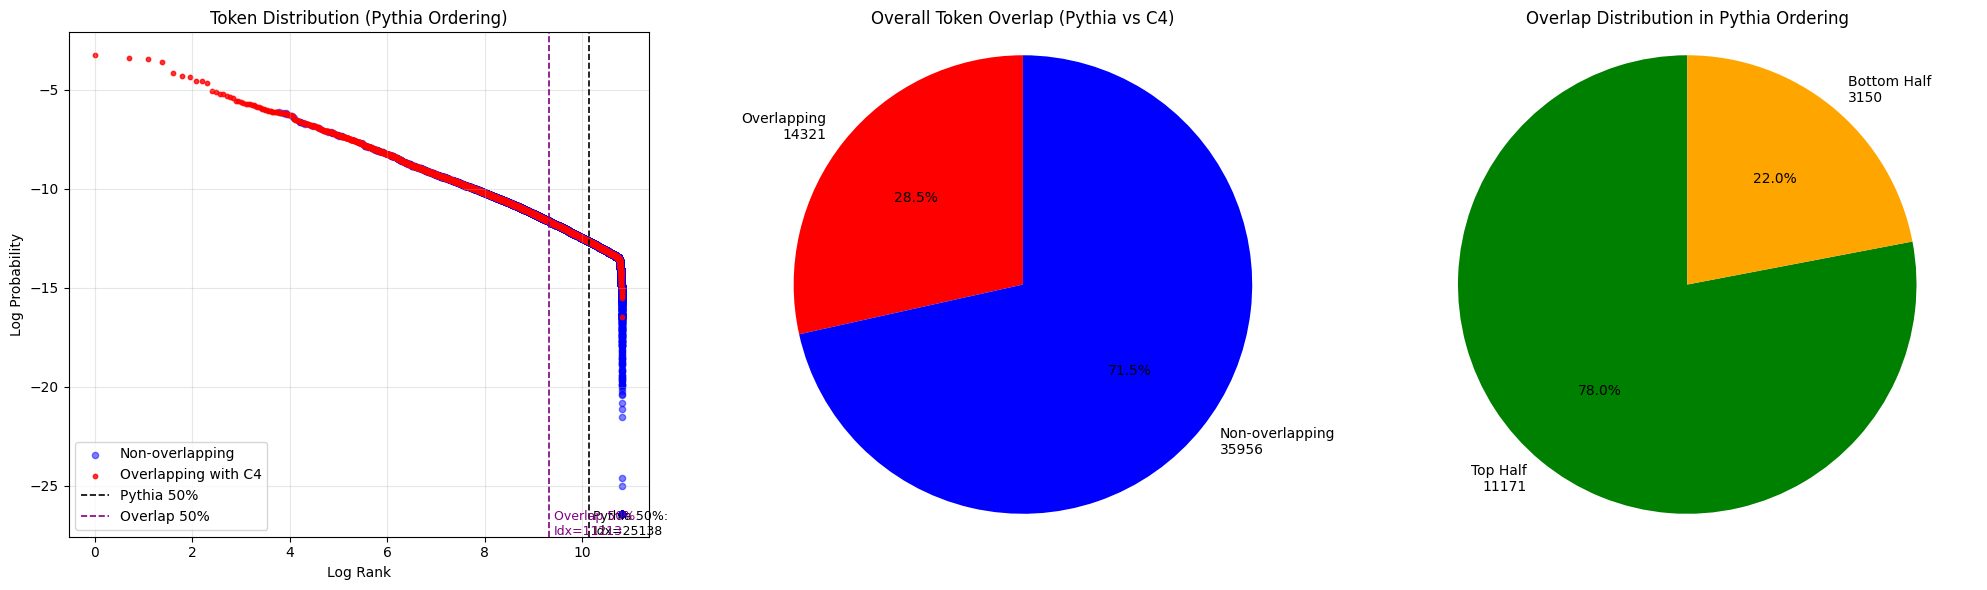

分析结果:
- Pythia 总 token 数: 50277
- 重合 token 数 (C4 与 Pythia): 14321
- Pythia 50% token 的位置 (索引): 25138，对应的 log rank: 10.13
- 重合 token 中前 50% 的位置 (索引): 11213，对应的 log rank: 9.32


In [156]:
# 确保您已有这些对象:
# - zipf_analyzer: ZipfThresholdAnalyzer实例
# - overlap_info: compare_c4_with_pythia_tokens()的结果 
# - token_ranks: token排名字典

# 运行简化版可视化
simple_token_overlap_viz(
    zipf_analyzer=zipf_analyzer,
    overlapping_tokens=overlap_info.get("overlapping_tokens", set()),
    token_ranks=token_ranks
)